In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from asodesigner.features.RBP_features import RBP_compatibility
from asodesigner.features.RBP_features import load_rbp_motif_table_rna
from asodesigner.features.RBP_features import get_motifs_by_cellline_rna
   



In [2]:
# conda activate aso_design
import pandas as pd
from scripts.data_genertion.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict
from asodesigner.consts import *
all_data = pd.read_csv(DATA_PATH / 'data_asoptimizer_updated.csv')
all_data.head()

/tmp/ipykernel_10115/1107691422.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(DATA_PATH / 'data_asoptimizer_updated.csv')


index    ISIS Target_gene Cell_line  Density(cells/well) Transfection  \
0      0  540733       K-RAS      A431               5000.0  free uptake   
1      1  540747       K-RAS      A431               5000.0  free uptake   
2      2  540806       K-RAS      A431               5000.0  free uptake   
3      3  651479       K-RAS      A431               5000.0  free uptake   
4      4  651490       K-RAS      A431               5000.0  free uptake   

   ASO_volume(nM)  Treatment_Period(hours) Primer_probe_set          Sequence  \
0          2000.0                       24      RTS3496_MGB  GCTAAAACAAATGCTA   
1          2000.0                       24      RTS3496_MGB  TATAATGGTGAATATC   
2          2000.0                       24      RTS3496_MGB  GCATGAAGATTTCTGG   
3          2000.0                       24      RTS3496_MGB  GGTGAATATCTTCAAA   
4          2000.0                       24      RTS3496_MGB  CACTTGTACTAGTATG   

   ... Inhibition(%) seq_length Canonical Gene Name Cell line organism  \
0  ...          33.0         16                KRAS              human   
1  ...           7.0         16                KRAS              human   
2  ...          62.0         16                KRAS              human   
3  ...          28.0         16                KRAS              human   
4  ...          36.0         16                KRAS              human   

  Transcript Location_in_sequence  Location_div_by_length  true_length_of_seq  \
0        NaN              41212.0                0.901972                  16   
1        NaN              23686.0                0.518395                  16   
2        NaN              43363.0                0.949049                  16   
3        NaN              23680.0                0.518264                  16   
4        NaN              41168.0                0.901009                  16   

  mod_scan cell_line_uniform  
0        0              A431  
1        0              A431  
2        1              A431  
3        0              A431  
4        0              A431  

[5 rows x 26 columns]

In [3]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")    

Feture generation

clean the data

In [4]:
import numpy as np

all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)

In [5]:
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [6]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR


cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [7]:
# =========================
# External mRNA integration
# =========================
import pandas as pd
from pathlib import Path
import re

def _norm_rna_to_dna(seq: str) -> str:
    """Normalize RNA to DNA alphabet (U->T), uppercase, strip whitespace."""
    return str(seq).upper().replace('U', 'T').replace(' ', '').replace('\t', '').replace('\n', '')


def load_mrna_by_gene_from_files(files: list[str | Path],seq_column: str = "Original Transcript Sequence" ) -> dict[str, str]:
    """
    Load {Gene -> <seq_column>} from a manual list of CSV paths.
    - Expects columns: 'Gene' and <seq_column>
    - Returns DNA alphabet (A/C/G/T) after U->T via _norm_rna_to_dna
    - If multiple rows per gene: keeps the *longest* sequence
    """
    files = [Path(f) for f in files]
    rows = []
    for f in files:
        df = pd.read_csv(f, usecols=['Gene', seq_column])
        df[seq_column] = df[seq_column].map(_norm_rna_to_dna)
        # Keep only clean sequences
        df = df[df[seq_column].str.fullmatch(r'[ACGT]+', na=False)]
        rows.append(df)

    if not rows:
        return {}

    big = pd.concat(rows, ignore_index=True)
    big['len'] = big[seq_column].str.len()
    # Pick longest per gene
    chosen = big.sort_values(['Gene', 'len'], ascending=[True, False]).drop_duplicates('Gene')
    return dict(zip(chosen['Gene'], chosen[seq_column]))

# ---- Choose which mRNA to use for mRNA-based features (tAI/windows on mRNA, etc.) ----
def choose_preferred_mrna(gene_name: str, mrna_built_from_exons: str, gene_to_mrna_real: dict[str,str]) -> str:
    """
    Prefer the real (external) mRNA when available; otherwise fall back to exon-joined.
    Does NOT touch your genome->(mRNA/CDS) mappings or pre-mRNA flanks.
    """
    ext = gene_to_mrna_real.get(gene_name)
    return ext if ext else mrna_built_from_exons


In [8]:
from pathlib import Path
import pandas as pd

DATA_mRNA_PATH = PROJECT_PATH / "scripts" / "data_genertion" / "cell_line_expression"

FILENAMES = [
    "ACH-000232_transcriptome.csv",
    "ACH-000463_transcriptome.csv",
    "ACH-000739_transcriptome.csv",
    "ACH-001086_transcriptome.csv",
    "ACH-001188_transcriptome.csv",
    "ACH-001328_transcriptome.csv",
]

EXTERNAL_MRNA_FILES = [DATA_mRNA_PATH / fn for fn in FILENAMES]
missing = [p.name for p in EXTERNAL_MRNA_FILES if not p.exists()]
assert not missing, f"Missing files in {DATA_mRNA_PATH}: {missing}"

# 1) Load Original
try:
    d_orig = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Original Transcript sequence"
    )
except ValueError:
    # in case the S is capitalized in your headers
    d_orig = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Original Transcript Sequence"
    )

# 2) Load Mutated
try:
    d_mut = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Mutated Transcript sequence"
    )
except ValueError:
    d_mut = load_mrna_by_gene_from_files(
        [str(p) for p in EXTERNAL_MRNA_FILES],
        seq_column="Mutated Transcript Sequence"
    )

# 3) Prefer Mutated when available
gene_to_mrna_real = {**d_orig, **d_mut}

print(f"Loaded {len(gene_to_mrna_real)} real mRNA sequences (Gene -> mRNA).")



Loaded 17546 real mRNA sequences (Gene -> mRNA).


In [9]:
from asodesigner.util import get_antisense
import numpy as np

# Filter relevant genes
all_data_human_gene = all_data_no_nan_human[
    all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)
].copy()

# Column names
SENSE_START       = 'sense_start'          # Genomic index of ASO binding site in pre-mRNA
SENSE_LENGTH      = 'sense_length'         # Length of the ASO (nt)
SENSE_TYPE        = 'sense_type'           # exon / intron
CDS_SEQUENCE      = 'cds_sequence'         # CDS string (joined exons within CDS range)
IN_CODING_REGION  = 'in_coding_region'     # site is within CDS on a real exon

# Flank sizes
FLANK_SIZES_PREMRNA = [20, 30, 40, 50, 60, 70]
FLANK_SIZES_CDS     = [20, 30, 40, 50, 60, 70]

# Initialize columns
all_data_human_gene[SENSE_START]      = 0
all_data_human_gene[SENSE_LENGTH]     = 0
all_data_human_gene[SENSE_TYPE]       = "NA"
all_data_human_gene[CDS_SEQUENCE]     = ""
all_data_human_gene[IN_CODING_REGION] = False

for fs in FLANK_SIZES_PREMRNA:
    all_data_human_gene[f"flank_sequence_{fs}"] = ""
for fs in FLANK_SIZES_CDS:
    all_data_human_gene[f"local_coding_region_around_ASO_{fs}"] = ""

# ---- helpers (local to Part B) ----
def _to_str_seq(x) -> str:
    """
    Coerce sequence-like (list/np.array/Series) or string to a clean uppercase DNA string.
    Converts U->T and strips whitespace. Ensures slicing returns a plain string (avoids pandas iterable assignment).
    """
    if isinstance(x, str):
        s = x
    else:
        try:
            s = ''.join(list(x))
        except Exception:
            s = str(x)
    return s.replace(' ', '').replace('\t', '').replace('\n', '').replace('U', 'T').upper()

def _build_spliced_mrna_from_exons(pre_mrna: str, exon_indices):
    """
    Build exon-joined mRNA by concatenating exon slices out of pre_mrna.
    Keeps your original assumptions: pre_mrna corresponds to genomic strand and
    starts at exon_indices[0][0]; exon intervals are used directly.
    """
    if not exon_indices:
        return ""
    pre_genome_start = exon_indices[0][0]
    parts = []
    for exon_start, exon_end in exon_indices:
        pm_start = exon_start - pre_genome_start
        pm_end   = exon_end   - pre_genome_start
        parts.append(pre_mrna[pm_start:pm_end])
    return "".join(parts)

# Cache CDS per gene
gene_to_cds_info = {}

# ---- main loop ----
for index, row in all_data_human_gene.iterrows():
    gene_name  = row[CANONICAL_GENE]
    locus_info = gene_to_data[gene_name]

    # Keep using your current pre-mRNA for flanks/exon-intron logic (coerced to clean string)
    pre_mrna  = _to_str_seq(locus_info.full_mrna)
    antisense = _to_str_seq(row[SEQUENCE])
    sense     = _to_str_seq(get_antisense(antisense))

    # Locate site on pre-mRNA
    idx = pre_mrna.find(sense)
    all_data_human_gene.at[index, SENSE_START]  = idx
    all_data_human_gene.at[index, SENSE_LENGTH] = len(antisense)

    if idx != -1:
        # Genomic correction (kept as-is)
        genome_corrected_index = idx + locus_info.exon_indices[0][0]

        # exon / intron classification (kept as-is: inclusive check)
        region_type = "intron"
        for exon_start, exon_end in locus_info.exon_indices:
            if exon_start <= genome_corrected_index <= exon_end:
                region_type = "exon"
                break
        all_data_human_gene.at[index, SENSE_TYPE] = region_type

        # pre-mRNA flanks (now using .at and guaranteed string slices)
        for fs in FLANK_SIZES_PREMRNA:
            flank_start = max(0, idx - fs)
            flank_end   = min(len(pre_mrna), idx + len(sense) + fs)
            flank_seq   = pre_mrna[flank_start:flank_end]
            all_data_human_gene.at[index, f"flank_sequence_{fs}"] = flank_seq

        # Build CDS + genome->mRNA map (kept identical to your approach)
        if gene_name not in gene_to_cds_info:
            cds_seq = []  # build as list for speed, join at end
            genome_to_mrna_map = {}
            mrna_idx = 0
            for exon_start, exon_end in locus_info.exon_indices:
                for gpos in range(exon_start, exon_end):
                    if mrna_idx >= len(pre_mrna):
                        break
                    if locus_info.cds_start <= gpos <= locus_info.cds_end:
                        cds_seq.append(pre_mrna[mrna_idx])
                        genome_to_mrna_map[gpos] = len(cds_seq) - 1
                    mrna_idx += 1
            cds_seq = ''.join(cds_seq)
            gene_to_cds_info[gene_name] = (cds_seq, genome_to_mrna_map)
        else:
            cds_seq, genome_to_mrna_map = gene_to_cds_info[gene_name]

        # Save CDS
        all_data_human_gene.at[index, CDS_SEQUENCE] = _to_str_seq(cds_seq)

        #  NEW: prefer real mRNA for mRNA-based features (fallback to exon-joined)
        mrna_built        = _build_spliced_mrna_from_exons(pre_mrna, locus_info.exon_indices)
        mrna_for_features = choose_preferred_mrna(gene_name, mrna_built, gene_to_mrna_real)

        # If within CDS, extract local CDS context (unchanged logic; .at + str)
        if (
            locus_info.cds_start <= genome_corrected_index <= locus_info.cds_end
            and genome_corrected_index in genome_to_mrna_map
        ):
            all_data_human_gene.at[index, IN_CODING_REGION] = True
            cds_idx = genome_to_mrna_map[genome_corrected_index]
            for fs in FLANK_SIZES_CDS:
                start = max(0, cds_idx - fs)
                end   = min(len(cds_seq), cds_idx + len(sense) + fs)
                local_seq = cds_seq[start:end]
                all_data_human_gene.at[index, f"local_coding_region_around_ASO_{fs}"] = _to_str_seq(local_seq)



In [10]:
# Filter genes that were not found in genome
all_data_human_gene_premrna = all_data_human_gene[all_data_human_gene[SENSE_START] != -1]



In [11]:

from sklearn.preprocessing import StandardScaler

# Define flank sizes
CDS_WINDOWS = FLANK_SIZES_CDS

# Loop over each flank window size
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    is_local_flag_col = f"region_is_local_{flank}"

    # Create the binary flag: 1 if local exists, 0 otherwise
    all_data_human_gene_premrna[is_local_flag_col] = all_data_human_gene_premrna[local_col].apply(
        lambda x: isinstance(x, str) and x.strip() != ""
    ).astype(int)




/tmp/ipykernel_10115/3972251179.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_human_gene_premrna[is_local_flag_col] = all_data_human_gene_premrna[local_col].apply(
/tmp/ipykernel_10115/3972251179.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_human_gene_premrna[is_local_flag_col] = all_data_human_gene_premrna[local_col].apply(
/tmp/ipykernel_10115/3972251179.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

creating the CAI features

In [12]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from scripts.data_genertion.consts import *

In [13]:
all_data_human_gene_premrna_no_nan = all_data_human_gene_premrna.copy()
filtered = all_data_human_gene_premrna_no_nan
filtered = filtered[filtered['Cell line organism'] == 'human']
filtered = filtered[filtered['Cell line organism'] == 'human']
print(len(filtered))
filtered = filtered.dropna(subset=[INHIBITION]).copy()
filtered = filtered.dropna(subset=[DENSITY]).copy()

ONE_HOT_FEATURE_NAMES = [ TRANSFECTION, MODIFICATION, SENSE_TYPE]
# append more one-hot features 'first_nucleotide', 'second_nucleotide'

for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    filtered = pd.get_dummies(filtered, columns=[one_hot_feature]).copy()

filtered.loc[:, 'log_volume'] = np.log(filtered[VOLUME])
filtered.loc[:, 'log_density'] = np.log(filtered[DENSITY])

# more feature generation
feature_base = [SENSE_START, SENSE_LENGTH]
experiment_features = [VOLUME, 'log_volume', 'log_density', TREATMENT_PERIOD]

one_hot_encoded_features = []
for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    one_hot_encoded_features.append([feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])

# Flatten the list of list to a single big list
flat_one_hot_encoded_features = [feature for sublist in one_hot_encoded_features for feature in sublist]

features = feature_base + experiment_features + flat_one_hot_encoded_features  

29987


/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
filtered["Cell_line"]



0        A431
1        A431
2        A431
3        A431
4        A431
         ... 
34760    A431
34761    A431
34762    A431
34763    A431
34764    A431
Name: Cell_line, Length: 29987, dtype: object

Feature generation

In [15]:
from asodesigner.features.RBP_features import RBP_compatibility

# Assumes:
# - `filtered` DataFrame exists
# - columns: "Sequence", "cds_sequence", and f"local_coding_region_around_ASO_{flank}" for each flank in CDS_WINDOWS
# - `RBP_compatibility(aso_seq, target_rna_seq, rbp_motifs)` is the updated, self-contained version we wrote

# Motifs (expanded where needed)
rbp_motifs_raw = [
    # HuR / ELAVL1
    "AUUUA",
    "UUAUUUAUU",
    # TTP / ZFP36
    "UAUUUAU",
    # PTBP1
    "UCUU", "CUCUCU", "UCUUC", "UUCUCU",
    # hnRNP A1
    "UAGGGA", "UAGGGU", "UAGG",
    # MBNL1 (YGCY consensus → commonly UGCU)
    "UGCU",
    # TDP-43 (UG repeats)
    "UG", "UGUG", "UGUGUG",
    # NOVA1/2 (YCAY → expand Y = {C, U})
    # "YCAY" expands to: UCAC, UCAU, CCAC, CCAU
]
rbp_motifs = rbp_motifs_raw + ["UCAC", "UCAU", "CCAC", "CCAU"]

# 1) Per-window RBP compatibility (CAI-style)
RBP_list = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_old_compatibility_{flank}"
    RBP_list.append(out_col)

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            (str(row[local_col]) if pd.notna(row[local_col]) else ""),
            rbp_motifs
        ),
        axis=1
    )

# 2) Global RBP compatibility on the full CDS (uses cds_sequence)
filtered["RBP_old_global_compatibility"] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        (str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else ""),
        rbp_motifs
    ),
    axis=1
)

# 3) Aggregation: min across all windows
filtered["RBP_old_compatibility_min_across_windows"] = filtered[RBP_list].min(axis=1)

# Keep a handy list of created columns
RBP_list = RBP_list + ["RBP_old_compatibility_min_across_windows", "RBP_old_global_compatibility"]


generate the RBP compatibility feature by function

In [16]:
# ============================================================
# RBP compatibility for DESTABILIZER motifs (RNA mode, clean version)
# ============================================================



# Load motifs and precompute dict: {cell_line: [destabilizer motifs]}
MOTIF_CSV_PATH = "RBP_motifs_for_each_cell_line_with_functional_role_expanded_with_A549.csv"
EXPR_THRESHOLD = 3.0

df_motifs = load_rbp_motif_table_rna(MOTIF_CSV_PATH)
destab_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["destabilizer"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_destab_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_destabilizer_{flank}"
    RBP_destab_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destab_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_destabilizer_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destab_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

# 3) Aggregation across windows
DESTAB_MINWIN = "RBP_compatibility_destabilizer_min_across_windows"
filtered[DESTAB_MINWIN] = filtered[RBP_destab_cols].min(axis=1)

# Handy list of created columns
RBP_destab_features = RBP_destab_cols + [DESTAB_MINWIN, DESTAB_GLOBAL]


In [17]:
# ============================================================
# RBP compatibility for stabilizer motifs 
# ============================================================



# Load motifs and precompute dict: {cell_line: [stabilizer motifs]}
EXPR_THRESHOLD = 3.0

stabilizer_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["stabilizer"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_stabilizer_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_stabilizer_{flank}"
    RBP_stabilizer_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_stabilizer_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

# 3) Aggregation across windows
DESTAB_MINWIN = "RBP_compatibility_stabilizer_min_across_windows"
filtered[DESTAB_MINWIN] = filtered[RBP_stabilizer_cols].min(axis=1)

# Handy list of created columns
RBP_stabilizer_features = RBP_stabilizer_cols + [DESTAB_MINWIN, DESTAB_GLOBAL]

In [18]:
# ============================================================
# RBP compatibility for splicing_regulator motifs 
# ============================================================



# Load motifs and precompute dict: {cell_line: [splicing_regulator motifs]}
EXPR_THRESHOLD = 3.0

splicing_regulator_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["splicing_regulator"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_splicing_regulator_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_splicing_regulator_{flank}"
    RBP_splicing_regulator_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_regulator_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_splicing_regulator_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destab_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

# 3) Aggregation across windows
DESTAB_MINWIN = "RBP_compatibility_splicing_regulator_min_across_windows"
filtered[DESTAB_MINWIN] = filtered[RBP_splicing_regulator_cols].min(axis=1)

# Handy list of created columns
RBP_splicing_regulator_features = RBP_splicing_regulator_cols + [DESTAB_MINWIN, DESTAB_GLOBAL]

In [19]:
# ============================================================
# RBP compatibility for translation_regulator motifs 
# ============================================================



# Load motifs and precompute dict: {cell_line: [translation_regulator motifs]}
EXPR_THRESHOLD = 3.0

translation_regulator_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["translation_regulator"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_translation_regulator_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_translation_regulator_{flank}"
    RBP_translation_regulator_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_regulator_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_translation_regulator_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_regulator_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

# 3) Aggregation across windows
DESTAB_MINWIN = "RBP_compatibility_translation_regulator_min_across_windows"
filtered[DESTAB_MINWIN] = filtered[RBP_translation_regulator_cols].min(axis=1)

# Handy list of created columns
RBP_translation_regulator_features = RBP_translation_regulator_cols + [DESTAB_MINWIN, DESTAB_GLOBAL]

In [ ]:
# ============================================================
# RBP compatibility for other/unclear motifs 
# ============================================================



# Load motifs and precompute dict: {cell_line: [other/unclear motifs]}
EXPR_THRESHOLD = 3.0

other_unclear_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["other/unclear"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_other_unclear_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_other_unclear_{flank}"
    RBP_other_unclear_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_unclear_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_other_unclear_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_unclear_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

# 3) Aggregation across windows
DESTAB_MINWIN = "RBP_compatibility_other_unclear_min_across_windows"
filtered[DESTAB_MINWIN] = filtered[RBP_other_unclear_cols].min(axis=1)

# Handy list of created columns
RBP_other_unclear_features = RBP_other_unclear_cols + [DESTAB_MINWIN, DESTAB_GLOBAL]

Generate the RBP overlap density features by the RBP function

In [ ]:
from asodesigner.features.RBP_features import overlap_density
# ============================================================
# RBP overlap density for DESTABILIZER motifs
# ============================================================

EXPR_THRESHOLD = 3.0

destabilizer_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["destabilizer"], expr_threshold=EXPR_THRESHOLD
)

RBP_destabilizer_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_destabilizer_{flank}"
    RBP_destabilizer_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

DESTAB_OVERLAP_GLOBAL = "RBP_overlap_density_destabilizer_global"
filtered[DESTAB_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_destabilizer_overlap_features = RBP_destabilizer_overlap_cols + [DESTAB_OVERLAP_GLOBAL]


In [ ]:

# ============================================================
# RBP overlap density for stabilizer motifs
# ============================================================

EXPR_THRESHOLD = 3.0

# If not already loaded above:
# df_motifs = load_rbp_motif_table_rna(MOTIF_CSV_PATH)

# Precompute {cell_line: [stabilizer motifs]}
stabilizer_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["stabilizer"], expr_threshold=EXPR_THRESHOLD
)

# 1) Per-window overlap density
RBP_stabilizer_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_stabilizer_{flank}"
    RBP_stabilizer_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global (full CDS) overlap density
STAB_OVERLAP_GLOBAL = "RBP_overlap_density_stabilizer_global"
filtered[STAB_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)


# Handy list of created columns
RBP_stabilizer_overlap_features = RBP_stabilizer_overlap_cols.append(STAB_OVERLAP_GLOBAL)


TypeError: can only concatenate list (not "str") to list

In [ ]:
# ============================================================
# RBP overlap density for SPLICING REGULATOR motifs
# ============================================================

EXPR_THRESHOLD = 3.0

splicing_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["splicing_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_splicing_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_splicing_regulator_{flank}"
    RBP_splicing_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

SPLICING_OVERLAP_GLOBAL = "RBP_overlap_density_splicing_regulator_global"
filtered[SPLICING_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_splicing_overlap_features = RBP_splicing_overlap_cols.append(SPLICING_OVERLAP_GLOBAL)


In [ ]:
# ============================================================
# RBP overlap density for TRANSLATION REGULATOR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

translation_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["translation_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_translation_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_translation_regulator_{flank}"
    RBP_translation_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

TRANSLATION_OVERLAP_GLOBAL = "RBP_overlap_density_translation_regulator_global"
filtered[TRANSLATION_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_translation_overlap_features = RBP_translation_overlap_cols.append(TRANSLATION_OVERLAP_GLOBAL)


In [ ]:
# ============================================================
# RBP overlap density for OTHER/UNCLEAR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

other_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["other/unclear"], expr_threshold=EXPR_THRESHOLD
)

RBP_other_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_other_unclear_{flank}"
    RBP_other_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

OTHER_OVERLAP_GLOBAL = "RBP_overlap_density_other_unclear_global"
filtered[OTHER_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_other_overlap_features = RBP_other_overlap_cols.append(OTHER_OVERLAP_GLOBAL)


Role-contrast indices features

In [ ]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from asodesigner.features.RBP_features import RBP_compatibility
from asodesigner.features.RBP_features import load_rbp_motif_table_rna
from asodesigner.features.RBP_features import get_motifs_by_cellline_rna

In [ ]:
# ============================================================
# Add role-contrast features for selected role pairs
#
# For each pair of roles, we create:
#   • Delta = density(role_a) – density(role_b)
#   • Ratio = density(role_a) / density(role_b)
#
# These features capture the relative balance between different
# categories of RBPs (e.g., destabilizers vs stabilizers).
#
# Notes:
# - Input columns come from overlap density features that were
#   already computed (e.g., RBP_overlap_density_<role>_<flank|global>).
# - Some roles have special characters (e.g., "other/unclear");
#   while they are used in the source column names, the new
#   contrast feature columns replace "/" with "_" for cleaner names.
#
# Example interpretation:
#   • Positive delta: role_a motifs dominate over role_b motifs.
#   • Negative delta: role_b motifs dominate.
#   • High ratio (>1): role_a context is stronger relative to role_b.
# ============================================================
from asodesigner.features.RBP_features import add_role_contrast_features
add_role_contrast_features(filtered, "destabilizer", "stabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "splicing_regulator", "translation_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "destabilizer", "splicing_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "destabilizer", "translation_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "other/unclear", "stabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "other/unclear", "destabilizer", CDS_WINDOWS)


ImportError: cannot import name 'add_role_contrast_features' from 'asodesigner.features.RBP_features' (/home/nivd1/ASOdesign-1/asodesigner/features/RBP_features.py)

RBP overlap frac features by RBP functions

In [ ]:
# ============================================================
# Positional splits for DESTABILIZER motifs (left/core/right)
# ============================================================
from asodesigner.features.RBP_features import positional_splits_exact_rna
EXPR_THRESHOLD = 3.0
destabilizer_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs, roles=["destabilizer"], expr_threshold=EXPR_THRESHOLD)

# 1) Per-window
RBP_destab_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_destabilizer_left_{flank}",
        f"RBP_overlap_frac_destabilizer_core_{flank}",
        f"RBP_overlap_frac_destabilizer_right_{flank}",
    ]
    RBP_destab_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

# 2) Global
DESTAB_POS_GLOBAL = [
    "RBP_overlap_frac_destabilizer_left_global",
    "RBP_overlap_frac_destabilizer_core_global",
    "RBP_overlap_frac_destabilizer_right_global",
]
filtered[DESTAB_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_destabilizer_positional_features = RBP_destab_pos_cols + [DESTAB_POS_GLOBAL]


In [ ]:
# ============================================================
# Positional splits for STABILIZER motifs (left/core/right)
# ============================================================

EXPR_THRESHOLD = 3.0
stabilizer_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["stabilizer"], expr_threshold=EXPR_THRESHOLD
)

RBP_stab_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_stabilizer_left_{flank}",
        f"RBP_overlap_frac_stabilizer_core_{flank}",
        f"RBP_overlap_frac_stabilizer_right_{flank}",
    ]
    RBP_stab_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

STAB_POS_GLOBAL = [
    "RBP_overlap_frac_stabilizer_left_global",
    "RBP_overlap_frac_stabilizer_core_global",
    "RBP_overlap_frac_stabilizer_right_global",
]
filtered[STAB_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_stabilizer_positional_features = RBP_stab_pos_cols + [STAB_POS_GLOBAL]


In [ ]:
# ============================================================
# Positional splits for SPLICING REGULATOR motifs
# ============================================================

EXPR_THRESHOLD = 3.0
splicing_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["splicing_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_splicing_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_splicing_regulator_left_{flank}",
        f"RBP_overlap_frac_splicing_regulator_core_{flank}",
        f"RBP_overlap_frac_splicing_regulator_right_{flank}",
    ]
    RBP_splicing_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

SPLICING_POS_GLOBAL = [
    "RBP_overlap_frac_splicing_regulator_left_global",
    "RBP_overlap_frac_splicing_regulator_core_global",
    "RBP_overlap_frac_splicing_regulator_right_global",
]
filtered[SPLICING_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_splicing_positional_features = RBP_splicing_pos_cols + [SPLICING_POS_GLOBAL]


In [ ]:
# ============================================================
# Positional splits for TRANSLATION REGULATOR motifs
# ============================================================

EXPR_THRESHOLD = 3.0
translation_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["translation_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_trans_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_translation_regulator_left_{flank}",
        f"RBP_overlap_frac_translation_regulator_core_{flank}",
        f"RBP_overlap_frac_translation_regulator_right_{flank}",
    ]
    RBP_trans_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                translation_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

TRANS_POS_GLOBAL = [
    "RBP_overlap_frac_translation_regulator_left_global",
    "RBP_overlap_frac_translation_regulator_core_global",
    "RBP_overlap_frac_translation_regulator_right_global",
]
filtered[TRANS_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            translation_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_translation_positional_features = RBP_trans_pos_cols + [TRANS_POS_GLOBAL]


In [ ]:
# ============================================================
# Positional splits for OTHER/UNCLEAR motifs
# ============================================================

EXPR_THRESHOLD = 3.0
other_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["other/unclear"], expr_threshold=EXPR_THRESHOLD
)

RBP_other_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_other_unclear_left_{flank}",
        f"RBP_overlap_frac_other_unclear_core_{flank}",
        f"RBP_overlap_frac_other_unclear_right_{flank}",
    ]
    RBP_other_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                other_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

OTHER_POS_GLOBAL = [
    "RBP_overlap_frac_other_unclear_left_global",
    "RBP_overlap_frac_other_unclear_core_global",
    "RBP_overlap_frac_other_unclear_right_global",
]
filtered[OTHER_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
                other_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
    ),
    axis=1
)

RBP_other_unclear_positional_features = RBP_other_pos_cols + [OTHER_POS_GLOBAL]


 Expression-weighted density features

In [ ]:
# ============================================================
# Expression-weighted density for TRANSLATION REGULATOR motifs
# ============================================================
from asodesigner.features.RBP_features import expression_weighted_density
from asodesigner.features.RBP_features import get_motifs_with_expr_by_cellline_rna
EXPR_THRESHOLD = 3.0

# Build: cell_line -> [(motif, expr), ...]
translation_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna( df_motifs,roles=["translation_regulator"],expr_threshold=EXPR_THRESHOLD)

# Per-window features
RBP_translation_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_translation_regulator_{flank}"
    RBP_translation_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# Global feature
TRANSLATION_WDENS_GLOBAL = "RBP_expr_weighted_density_translation_regulator_global"
filtered[TRANSLATION_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_translation_wdens_features = RBP_translation_wdens_cols + [TRANSLATION_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for DESTABILIZER motifs
# ============================================================
EXPR_THRESHOLD = 3.0

destabilizer_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["destabilizer"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_destabilizer_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_destabilizer_{flank}"
    RBP_destabilizer_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

DESTABILIZER_WDENS_GLOBAL = "RBP_expr_weighted_density_destabilizer_global"
filtered[DESTABILIZER_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_destabilizer_wdens_features = RBP_destabilizer_wdens_cols + [DESTABILIZER_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for STABILIZER motifs
# ============================================================
EXPR_THRESHOLD = 3.0

stabilizer_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["stabilizer"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_stabilizer_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_stabilizer_{flank}"
    RBP_stabilizer_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

STABILIZER_WDENS_GLOBAL = "RBP_expr_weighted_density_stabilizer_global"
filtered[STABILIZER_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_stabilizer_wdens_features = RBP_stabilizer_wdens_cols + [STABILIZER_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for SPLICING REGULATOR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

splicing_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["splicing_regulator"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_splicing_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_splicing_regulator_{flank}"
    RBP_splicing_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

SPLICING_WDENS_GLOBAL = "RBP_expr_weighted_density_splicing_regulator_global"
filtered[SPLICING_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        splicing_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_splicing_wdens_features = RBP_splicing_wdens_cols + [SPLICING_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for OTHER / UNCLEAR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

other_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["other/unclear"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_other_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_other_unclear_{flank}"
    RBP_other_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

OTHER_WDENS_GLOBAL = "RBP_expr_weighted_density_other_unclear_global"
filtered[OTHER_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_other_wdens_features = RBP_other_wdens_cols + [OTHER_WDENS_GLOBAL]


motif diversity features

In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for DESTABILIZER
# ============================================================
EXPR_THRESHOLD = 3.0
from asodesigner.features.RBP_features import motif_diversity_window_ratio
from asodesigner.features.RBP_features import get_motif_identity_pairs_by_cellline

destabilizer_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="destabilizer", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_destabilizer_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_destabilizer_{flank}"
    RBP_destabilizer_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

DESTABILIZER_DIV_GLOBAL = "RBP_motif_diversity_destabilizer_global"
filtered[DESTABILIZER_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_destabilizer_diversity_features = RBP_destabilizer_diversity_cols + [DESTABILIZER_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for STABILIZER
# ============================================================
EXPR_THRESHOLD = 3.0

stabilizer_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="stabilizer", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_stabilizer_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_stabilizer_{flank}"
    RBP_stabilizer_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

STABILIZER_DIV_GLOBAL = "RBP_motif_diversity_stabilizer_global"
filtered[STABILIZER_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_stabilizer_diversity_features = RBP_stabilizer_diversity_cols + [STABILIZER_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for SPLICING REGULATOR
# ============================================================
EXPR_THRESHOLD = 3.0

splicing_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="splicing_regulator", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_splicing_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_splicing_regulator_{flank}"
    RBP_splicing_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

SPLICING_DIV_GLOBAL = "RBP_motif_diversity_splicing_regulator_global"
filtered[SPLICING_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        splicing_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_splicing_diversity_features = RBP_splicing_diversity_cols + [SPLICING_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for TRANSLATION REGULATOR
# ============================================================
EXPR_THRESHOLD = 3.0

translation_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="translation_regulator", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_translation_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_translation_regulator_{flank}"
    RBP_translation_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

TRANSLATION_DIV_GLOBAL = "RBP_motif_diversity_translation_regulator_global"
filtered[TRANSLATION_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_translation_diversity_features = RBP_translation_diversity_cols + [TRANSLATION_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for OTHER / UNCLEAR
# ============================================================
EXPR_THRESHOLD = 3.0

other_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="other/unclear", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_other_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_other_unclear_{flank}"
    RBP_other_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

OTHER_DIV_GLOBAL = "RBP_motif_diversity_other_unclear_global"
filtered[OTHER_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_other_diversity_features = RBP_other_diversity_cols + [OTHER_DIV_GLOBAL]


Remove the sequence columns

 Save each feature as CSV in the features directory

In [ ]:
"""""
from scripts.features.feature_extraction import save_feature
feature_list =CAI_list
for feat in feature_list:
    save_feature(filtered, feat)
"""


'""\nfrom scripts.features.feature_extraction import save_feature\nfeature_list =CAI_list\nfor feat in feature_list:\n    save_feature(filtered, feat)\n'

 Save DataFrame as CSV in the current working directory

In [ ]:

#new_filtered.to_csv("features_output_final_update_CUB_final2.csv", index=False)

test the features

In [ ]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")    

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, entropy
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def compute_entropy(series, bins=20):
    series = series.astype(float)
    hist, _ = np.histogram(series, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)

def analyze_feature_correlations(df, target, features=None, verbose=False, bins=20):
    """
    Analyzes Pearson, Spearman, and Normalized Mutual Information (NMI_max) between features and a target variable.

    Parameters:
    -----------
    df : pd.DataFrame
    target : str
        Name of the target column.
    features : list of str, optional
        Feature names. If None, use all columns except the target.
    verbose : bool
        Print error messages if True.
    bins : int
        Number of bins for entropy estimation.

    Returns:
    --------
    pd.DataFrame with Pearson, Spearman, and NMI_max results.
    """
    if features is None:
        features = [col for col in df.columns if col != target]

    results = []

    for feature in features:
        try:
            # Drop rows with NaN in either the feature or the target
            valid_mask = df[[feature, target]].notnull().all(axis=1)
            x = df.loc[valid_mask, feature].values
            y = df.loc[valid_mask, target].values

            # Skip if there's not enough data
            if len(x) < 3:
                raise ValueError("Not enough valid data points.")

            pearson_corr, pearson_p = pearsonr(x, y)
            spearman_corr, spearman_p = spearmanr(x, y)
            mi = mutual_info_regression(x.reshape(-1, 1), y, discrete_features='auto')[0]

            H_x = compute_entropy(x, bins=bins)
            H_y = compute_entropy(y, bins=bins)

            nmi_max = mi / max(H_x, H_y) if max(H_x, H_y) > 0 else np.nan

            results.append({
                'Feature': feature,
                'Pearson': round(pearson_corr, 3),
                'Spearman': round(spearman_corr, 3),
                'NMI_max': round(nmi_max, 3)
            })

        except Exception as e:
            if verbose:
                print(f"Error with feature '{feature}': {e}")
            results.append({
                'Feature': feature,
                'Pearson': None,
                'Spearman': None,
                'NMI_max': None
            })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by="NMI_max", ascending=False, inplace=True)
    return results_df


In [ ]:
import matplotlib.pyplot as plt

def plot_feature_correlations_by_prefix(results_df, prefix, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for features starting with a given prefix.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results (from analyze_feature_correlations).
    prefix : str
        The prefix to filter feature names (e.g., 'tAI_score').
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by prefix
    subset_df = results_df[results_df['Feature'].str.startswith(prefix)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", 'NMI_max'])
    
    if subset_df.empty:
        print(f"No features found starting with '{prefix}'")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title(f"Correlation Metrics for Features Starting with '{prefix}'")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



def plot_selected_feature_correlations_from_list(results_df, feature_list, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for a given list of features.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results.
    feature_list : list of str
        The list of feature names to include in the plot.
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by exact name match from list
    subset_df = results_df[results_df['Feature'].isin(feature_list)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", "NMI_max"])
    
    if subset_df.empty:
        print("No matching features found in the provided list.")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title("Correlation Metrics for Selected Features")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:

results_df = analyze_feature_correlations(filtered, target='log_inhibition')
display(results_df)


/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4623: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean


Feature  Pearson  Spearman  NMI_max
14                      Inhibition(%)    0.880     1.000    2.450
1                                ISIS   -0.051    -0.129    0.182
24                        sense_start   -0.027     0.199    0.129
19               Location_in_sequence   -0.022     0.204    0.129
0                               index    0.337     0.325    0.114
..                                ...      ...       ...      ...
36  local_coding_region_around_ASO_40      NaN       NaN      NaN
37  local_coding_region_around_ASO_50      NaN       NaN      NaN
38  local_coding_region_around_ASO_60      NaN       NaN      NaN
39  local_coding_region_around_ASO_70      NaN       NaN      NaN
61                        log_density      NaN       NaN      NaN

[145 rows x 4 columns]

Compatibility features

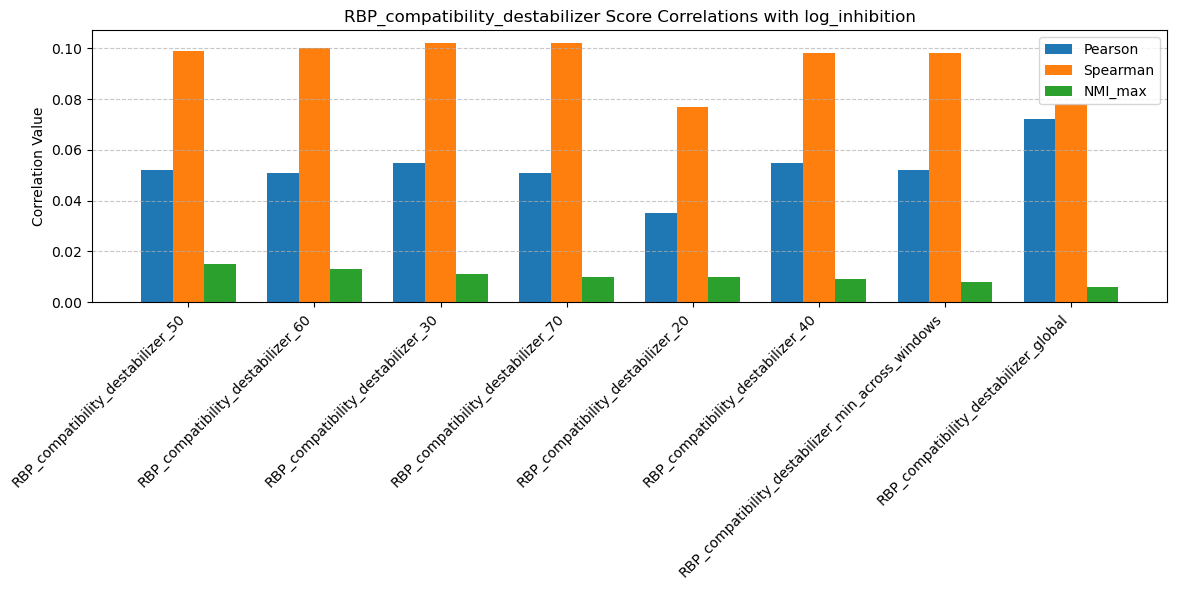

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_destabilizer', title='RBP_compatibility_destabilizer Score Correlations with log_inhibition')

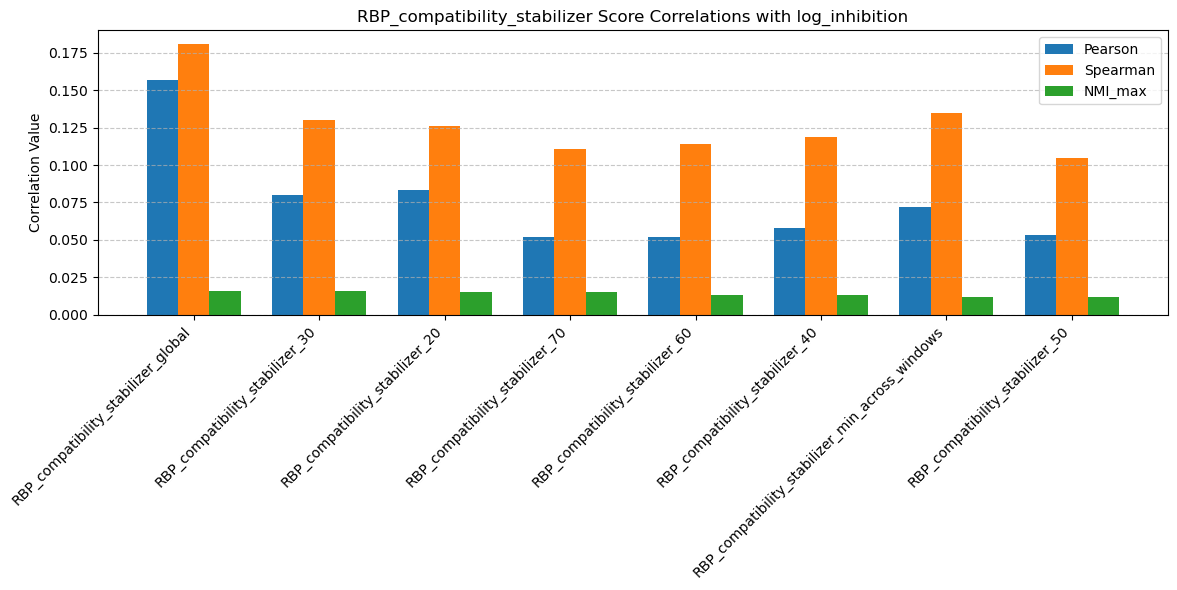

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_stabilizer', title='RBP_compatibility_stabilizer Score Correlations with log_inhibition')


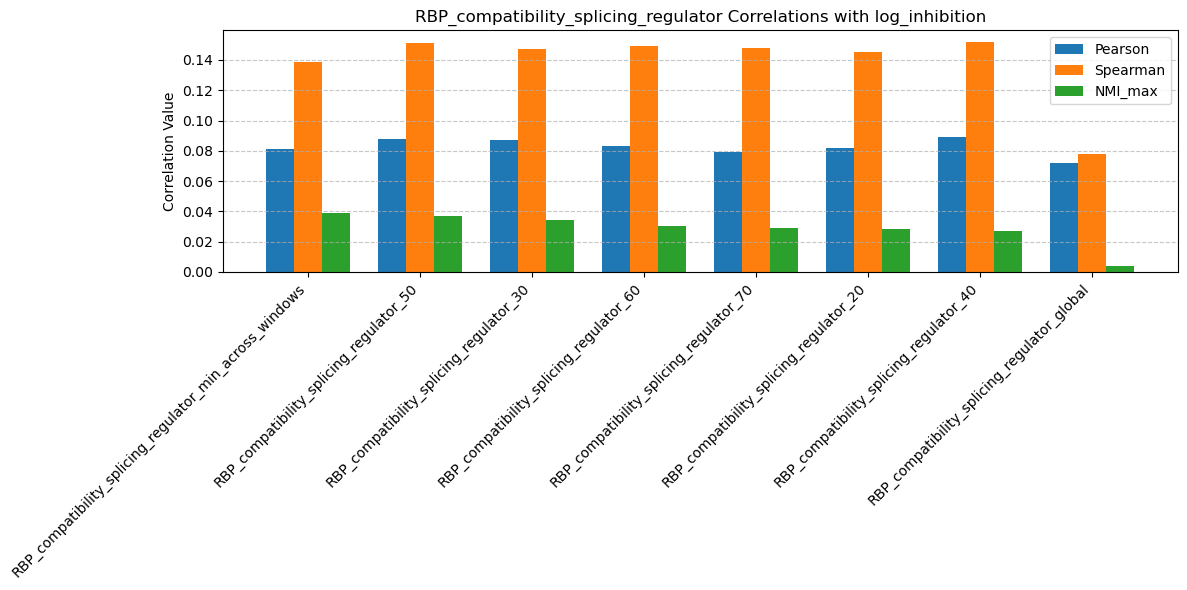

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_splicing_regulator', title='RBP_compatibility_splicing_regulator Correlations with log_inhibition')

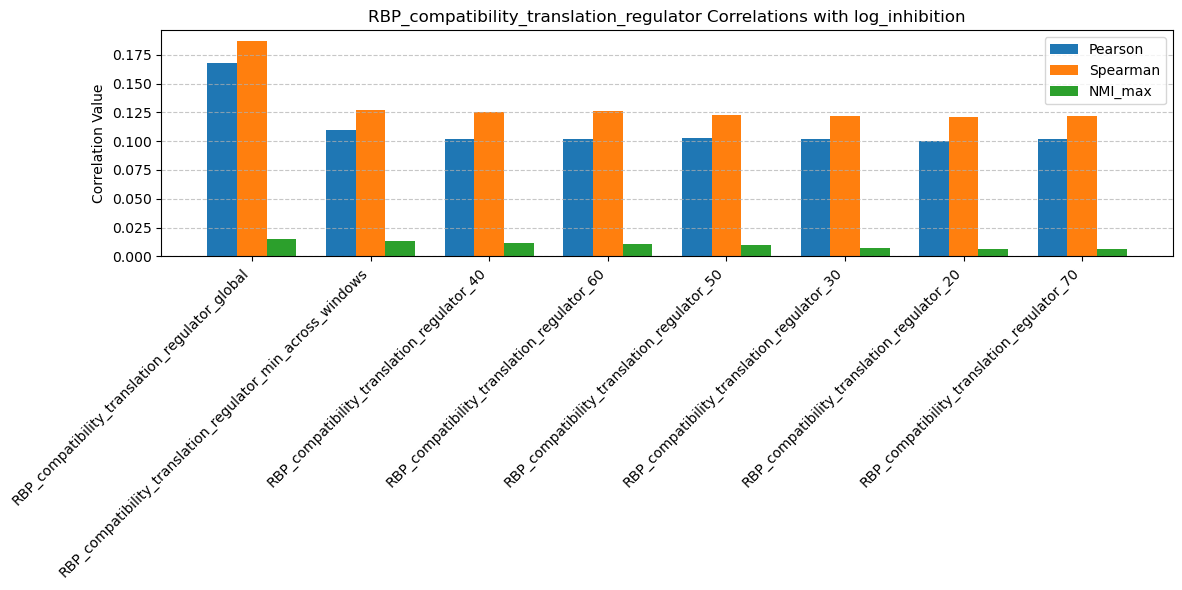

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_translation_regulator', title='RBP_compatibility_translation_regulator Correlations with log_inhibition')





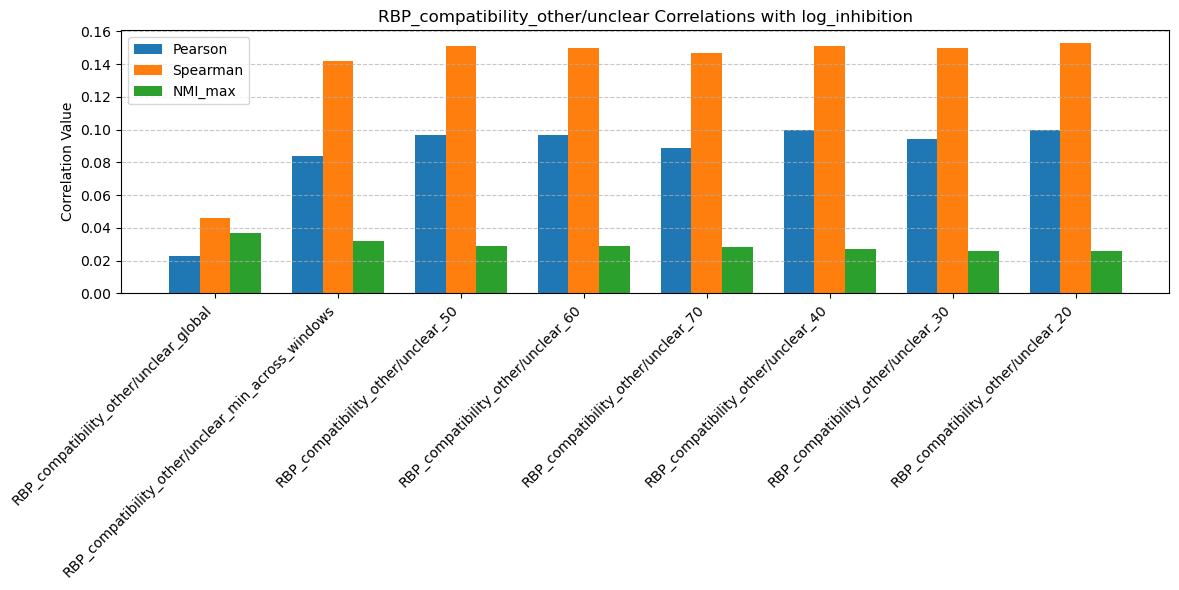

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_other_unclear', title='RBP_compatibility_other_unclear Correlations with log_inhibition')

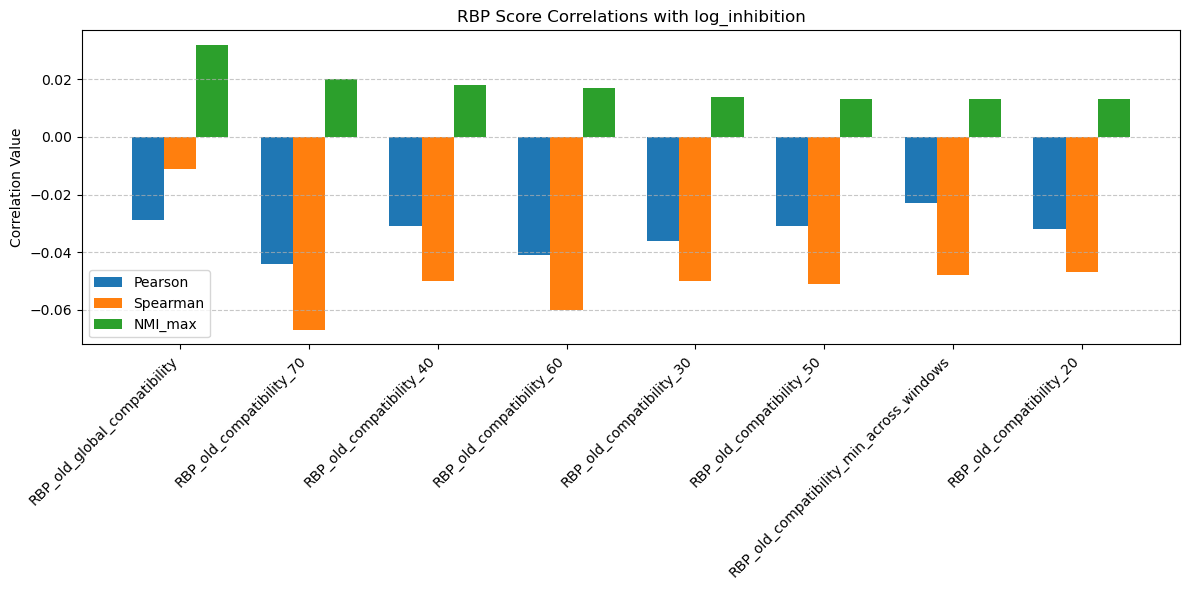

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_old', title='RBP Score Correlations with log_inhibition')


overlap_density features

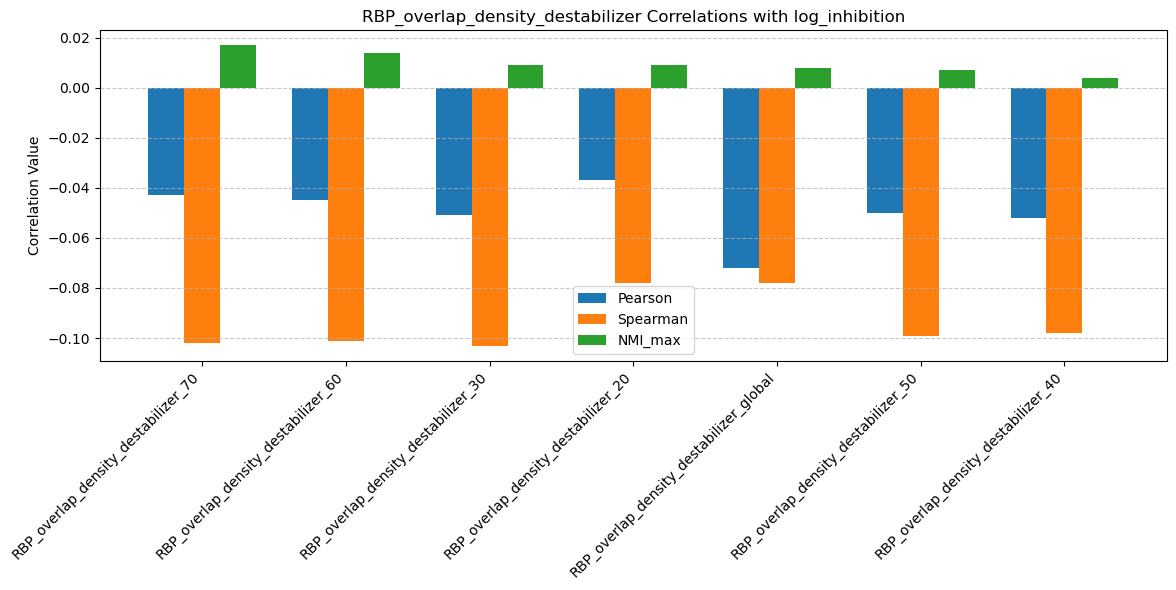

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_destabilizer', title='RBP_overlap_density_destabilizer Correlations with log_inhibition')



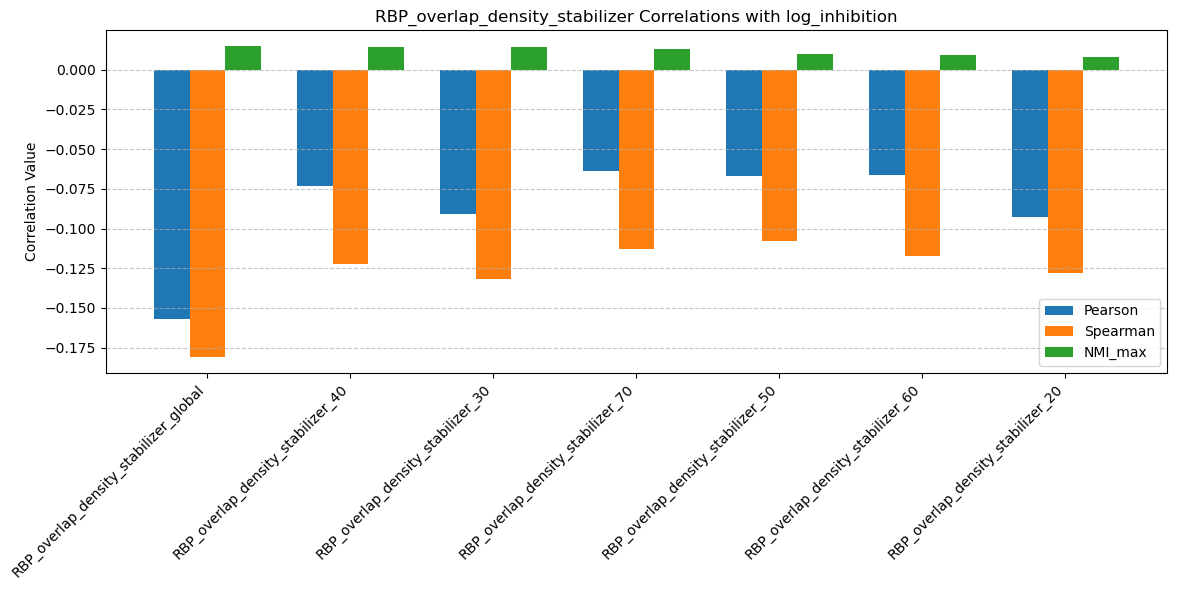

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_stabilizer', title='RBP_overlap_density_stabilizer Correlations with log_inhibition')


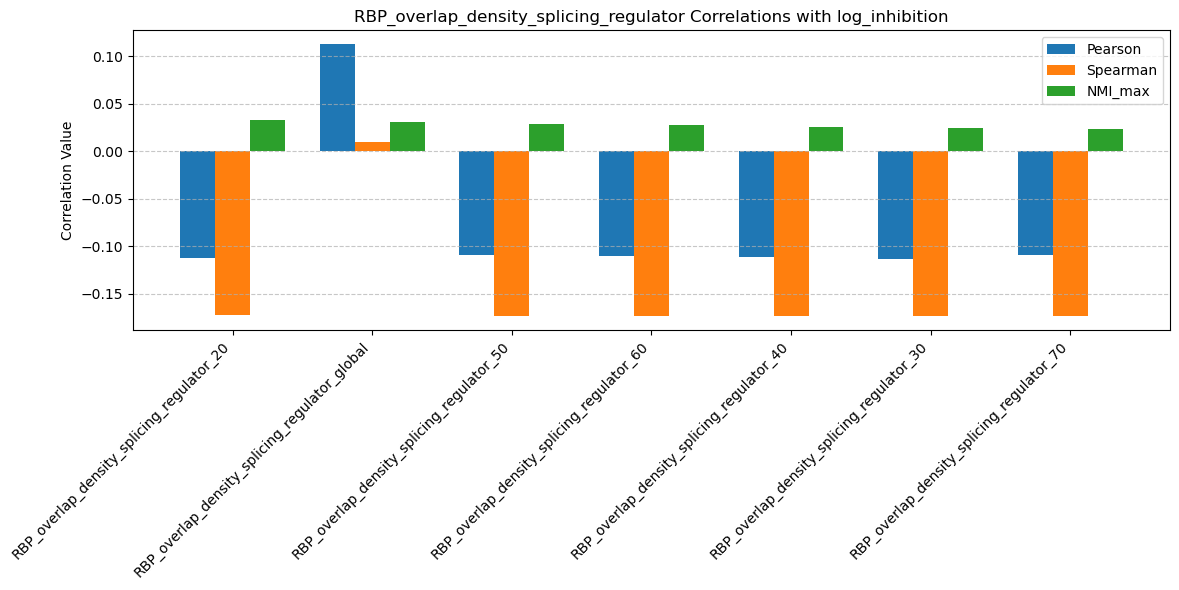

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_splicing_regulator', title='RBP_overlap_density_splicing_regulator Correlations with log_inhibition')

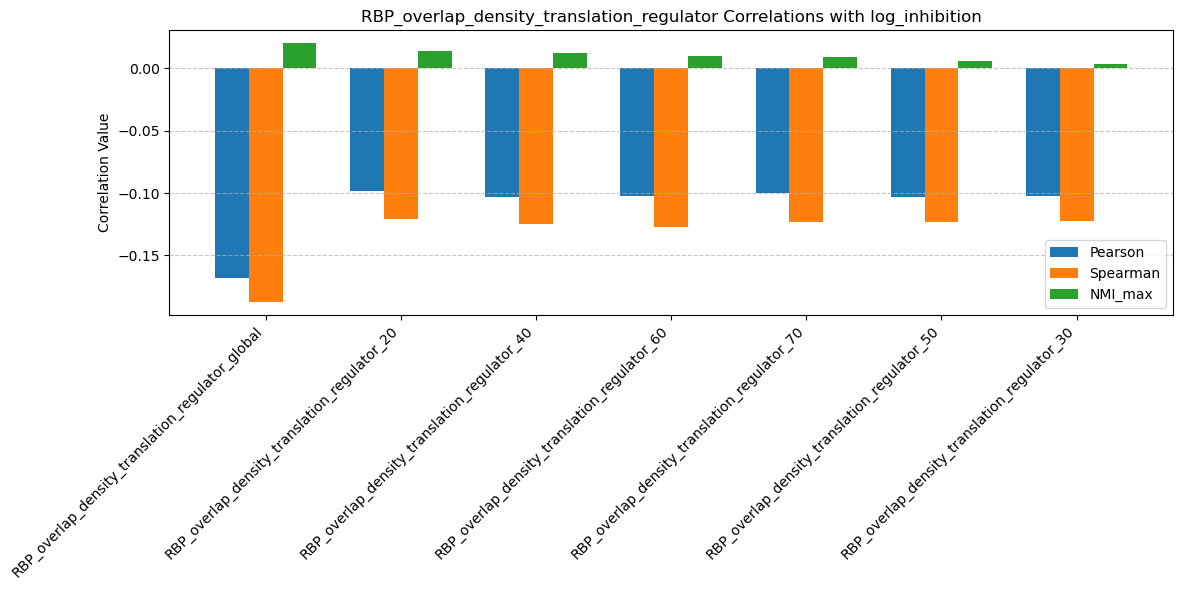

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_translation_regulator', title='RBP_overlap_density_translation_regulator Correlations with log_inhibition')


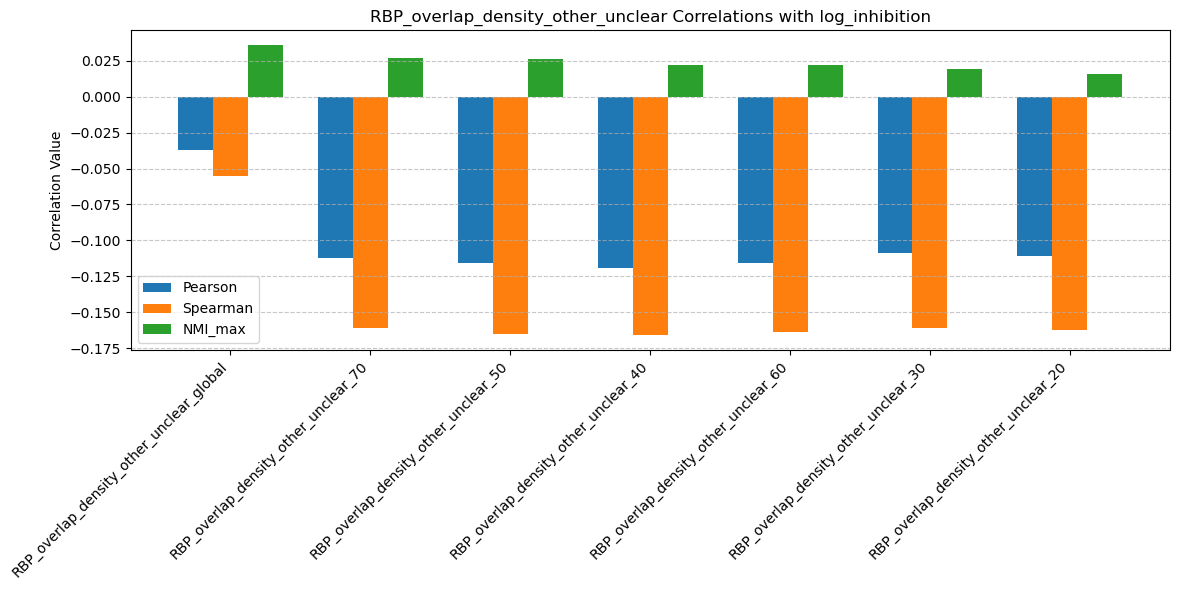

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_other_unclear', title='RBP_overlap_density_other_unclear Correlations with log_inhibition')

ratio and delta features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__destabilizer_vs_stabilizer', title='RBP_overlap_delta__destabilizer_vs_stabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__destabilizer_vs_stabilizer', title='RBP_overlap_ratio__destabilizer_vs_stabilizer Correlations with log_inhibition')


In [ ]:
add_role_contrast_features(filtered, "destabilizer", "stabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "splicing_regulator", "translation_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "destabilizer", "splicing_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "destabilizer", "translation_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "other/unclear", "stabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "other/unclear", "destabilizer", CDS_WINDOWS)

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__destabilizer_vs_splicing_regulator', title='RBP_overlap_delta__destabilizer_vs_splicing_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__destabilizer_vs_splicing_regulator', title='RBP_overlap_ratio__destabilizer_vs_splicing_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__destabilizer_vs_translation_regulator', title='RBP_overlap_delta__destabilizer_vs_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__destabilizer_vs_translation_regulator', title='RBP_overlap_ratio__destabilizer_vs_translation_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__splicing_regulator_vs_translation_regulator', title='RBP_overlap_delta__splicing_regulator_vs_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__splicing_regulator_vs_translation_regulator', title='RBP_overlap_ratio__splicing_regulator_vs_translation_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__other_unclear_vs_stabilizer', title='RBP_overlap_delta__other_unclear_vs_stabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__other_unclear_vs_stabilizer', title='RBP_overlap_ratio__other_unclear_vs_stabilizer Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__other_unclear_vs_destabilizer', title='RBP_overlap_delta__other_unclear_vs_destabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__other_unclear_vs_destabilizer', title='RBP_overlap_ratio__other_unclear_vs_destabilizer Correlations with log_inhibition')


RBP overlap frac features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_destabilizer_left_', title='RBP_overlap_frac_destabilizer_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_destabilizer_core_', title='RBP_overlap_frac_destabilizer_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_destabilizer_right_', title='RBP_overlap_frac_destabilizer_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stabilizer_left_', title='RBP_overlap_frac_stabilizer_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stabilizer_core_', title='RBP_overlap_frac_stabilizer_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stabilizer_right_', title='RBP_overlap_frac_stabilizer_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_splicing_regulator_left_', title='RBP_overlap_frac_splicing_regulator_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_splicing_regulator_core_', title='RBP_overlap_frac_splicing_regulator_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_splicing_regulator_right_', title='RBP_overlap_frac_splicing_regulator_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stranslation_regulator_left_', title='RBP_overlap_frac_translation_regulator_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_translation_regulator_core_', title='RBP_overlap_frac_translation_regulator_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_translation_regulator_right_', title='RBP_overlap_frac_translation_regulator_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_other_unclear_left_', title='RBP_overlap_frac_other_unclear_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_other_unclear_core_', title='RBP_overlap_frac_other_unclear_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_other_unclear_right_', title='RBP_overlap_frac_other_unclear_right part of the ASO Correlations with log_inhibition')

No features found starting with 'RBP_overlap_frac_other_unclear_left_'


Weighted density features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_destabilizer', title='RBP_expr_weighted_density_destabilizerr Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_stabilizer', title='RBP_expr_weighted_density_stabilizer Correlations with log_inhibition') 
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_splicing_regulator', title='RBP_expr_weighted_density_splicing_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_translation_regulator', title='RBP_expr_weighted_density_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_other_unclear', title='RBP_expr_weighted_density_other_unclear Correlations with log_inhibition')      


Motif diversity features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_destabilizer', title='RBP_motif_diversity_destabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_stabilizer', title='RBP_motif_diversity_stabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_splicing_regulator', title='RBP_motif_diversity_splicing_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_translation_regulator', title='RBP_motif_diversity_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_other_unclear', title='RBP_motif_diversity_other_unclear Correlations with log_inhibition')